Node representation learning with attri2vec tutorial

In [28]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random

import stellargraph as sg
from stellargraph.data import UnsupervisedSampler
from stellargraph.mapper import Attri2VecLinkGenerator, Attri2VecNodeGenerator
from stellargraph.layer import Attri2Vec, link_classification

from tensorflow import keras

from pandas.core.indexes.base import Index

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

from stellargraph import datasets
from IPython.display import display, HTML

In [29]:
dataset = datasets.CiteSeer()
display(HTML(dataset.description))
G, subjects = dataset.load(largest_connected_component_only=True)

In [30]:
import random
k = 24
# sampled_nodes = random.sample(list(G.nodes()), k)
SG = G.subgraph(['364207', '100157', '38848', 'bradshaw97introduction', 'bylund99coordinating', 'dix01metaagent',
                            'gray99finding', 'labrou01standardizing', 'labrou99agent', 'nodine98overview', 'nodine99active',
                            'wagner97artificial', '455651', '100598', 'marquez00machine', 'punyakanok01use', '104129', '106003',
                            'singhal99document', 'amer-yahia00boundingschemas', '106339', 'arlein99making', 'cluet99using', 
                            'shasha02algorithmics', '184462', '108321', '73962'])

In [31]:
G = SG

In [32]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 27, Edges: 27

 Node types:
  paper: [27]
    Features: float32 vector, length 3703
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [27]
        Weights: all 1 (default)
        Features: none


In [33]:
nodes = list(G.nodes())
number_of_walks = 4
length = 5

In [34]:
unsupervised_samples = UnsupervisedSampler(
    G, nodes=nodes, length=length, number_of_walks=number_of_walks
)

In [35]:
batch_size = 4
epochs = 4

In [36]:
generator = Attri2VecLinkGenerator(G, batch_size)
train_gen = generator.flow(unsupervised_samples)

In [37]:
layer_sizes = [5]
attri2vec = Attri2Vec(
    layer_sizes=layer_sizes, generator=generator, bias=False, normalize=None
)

In [38]:
# Build the model and expose input and output sockets of attri2vec, for node pair inputs:
x_inp, x_out = attri2vec.in_out_tensors()

In [39]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [40]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

/Users/mmarzi/.pyenv/versions/3.8.0/envs/graphs/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [41]:
history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=2,
    use_multiprocessing=False,
    workers=1,
    shuffle=True,
)

Epoch 1/4
216/216 - 0s - loss: 0.6924 - binary_accuracy: 0.5243
Epoch 2/4
216/216 - 0s - loss: 0.6859 - binary_accuracy: 0.5637
Epoch 3/4
216/216 - 0s - loss: 0.6762 - binary_accuracy: 0.5845
Epoch 4/4
216/216 - 0s - loss: 0.6556 - binary_accuracy: 0.6759


In [42]:
x_inp_src = x_inp[0]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

In [43]:
node_gen = Attri2VecNodeGenerator(G, batch_size).flow(list(G.nodes()))
node_embeddings = embedding_model.predict(node_gen, workers=1, verbose=1)

7/7 [==============================] - 0s 718us/step


In [68]:
transform = PCA #TSNE  # 

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

In [71]:
node_embeddings_2d

array([[-0.7720094 ,  0.08032539],
       [-0.68374884, -0.1952469 ],
       [-0.82418585,  0.13812214],
       [-0.715395  , -0.21193498],
       [-0.59300387, -0.28401697],
       [-0.6409275 ,  0.10005263],
       [-0.6105973 , -0.11733919],
       [-0.6398432 , -0.14113382],
       [-0.72544163, -0.08455043],
       [-0.64663655, -0.32644626],
       [-0.58641446, -0.23602884],
       [-0.7628066 , -0.02945691],
       [ 0.84461725,  0.42076892],
       [ 0.86105824,  0.51094043],
       [ 0.7877055 ,  0.4355781 ],
       [ 0.8121965 ,  0.48337752],
       [ 0.4064281 ,  0.02566892],
       [ 0.20682105, -0.00316773],
       [ 0.2369845 , -0.01696417],
       [ 0.7383426 , -0.6535916 ],
       [ 0.8054668 , -0.6424189 ],
       [ 0.7497774 , -0.70078695],
       [ 0.77151865, -0.6955104 ],
       [ 0.7447565 , -0.6779075 ],
       [ 0.05513987,  0.943663  ],
       [ 0.09231991,  0.9548896 ],
       [ 0.0878774 ,  0.92311543]], dtype=float32)

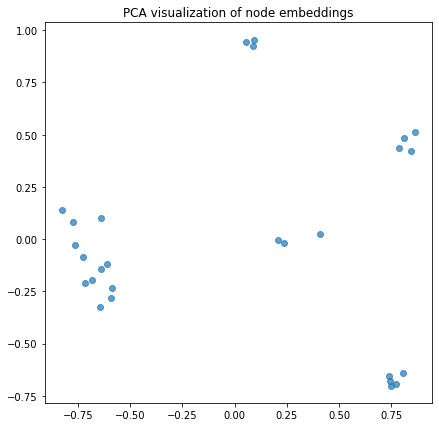

In [72]:
# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(subjects))}
node_colours = [label_map[target] for target in subjects]

plt.figure(figsize=(7, 7))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    # c=node_colours,
    cmap="jet",
    alpha=alpha,
)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()

In [57]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 27, Edges: 27

 Node types:
  paper: [27]
    Features: float32 vector, length 3703
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [27]
        Weights: all 1 (default)
        Features: none


In [62]:
G.nodes()

Index(['364207', '100157', '38848', 'bradshaw97introduction',
       'bylund99coordinating', 'dix01metaagent', 'gray99finding',
       'labrou01standardizing', 'labrou99agent', 'nodine98overview',
       'nodine99active', 'wagner97artificial', '455651', '100598',
       'marquez00machine', 'punyakanok01use', '104129', '106003',
       'singhal99document', 'amer-yahia00boundingschemas', '106339',
       'arlein99making', 'cluet99using', 'shasha02algorithmics', '184462',
       '108321', '73962'],
      dtype='object')

In [65]:
G.node_features(["364207"]).shape

(1, 3703)

----

# Attri2vec on Soil food web

In [ ]:
g = G.copy()
G_att = G.copy()

import pickle
trophic_levels_dict = pickle.load( open( "results/trophic_levels_dict.pickle", "rb" ) )
avg_biomass_A = pickle.load( open( "results/avg_biomass_A.pickle", "rb") )
avg_mass_A = pickle.load( open( "results/avg_mass_A.pickle", "rb") )
avg_abund_A = pickle.load( open( "results/avg_abund_A.pickle", "rb") )

# Add attributes to derived graph.
nx.set_node_attributes(G_att, trophic_levels_dict, "trophic_level")
nx.set_node_attributes(G_att, avg_biomass_A, "Biomass")
nx.set_node_attributes(G_att, avg_mass_A, "Mass")
nx.set_node_attributes(G_att, avg_abund_A, "Abundance")

# G.nodes(data=True)

In [ ]:
# TEST standardisation
# from sklearn.preprocessing import StandardScaler
    
# scalled_avg_biomass_A = StandardScaler().fit_transform(avg_biomass_A)
# # scalled_avg_biomass_A = pd.DataFrame(scaled_array, columns=scalled_avg_biomass_A.columns)

In [ ]:
d = {}

for node, node_data in G_att.nodes(data=True):
    d[node] = list(node_data.values())

nx.set_node_attributes(G_att, d, name="features")

In [ ]:
from stellargraph import StellarGraph
from stellargraph.data import UnsupervisedSampler
from stellargraph.mapper import Attri2VecLinkGenerator, Attri2VecNodeGenerator
from stellargraph.layer import Attri2Vec, link_classification

from tensorflow import keras

from pandas.core.indexes.base import Index

In [ ]:
SG_att = StellarGraph.from_networkx(G_att, node_features="features")

In [ ]:
print(SG_att.info())

In [ ]:
nodes = list(SG_att.nodes())
number_of_walks = 20
length = 5

unsupervised_samples = UnsupervisedSampler(
    SG_att, nodes=nodes, length=length, number_of_walks=number_of_walks
)

batch_size = 50
epochs = 4

generator = Attri2VecLinkGenerator(SG_att, batch_size)
train_gen = generator.flow(unsupervised_samples)

layer_sizes = [5]
attri2vec = Attri2Vec(
    layer_sizes=layer_sizes, generator=generator, bias=False, normalize=None
)

# Build the model and expose input and output sockets of attri2vec, for node pair inputs:
x_inp, x_out = attri2vec.in_out_tensors()

prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip")(x_out)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)


history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=2,
    use_multiprocessing=False,
    workers=1,
    shuffle=True,
)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

x_inp_src = x_inp[0]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

node_gen = Attri2VecNodeGenerator(SG_att, batch_size).flow(list(SG_att.nodes()))
node_embeddings = embedding_model.predict(node_gen, workers=1, verbose=1)

transform = TSNE #PCA   # 

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.7
# label_map = {l: i for i, l in enumerate(np.unique(subjects))}
# node_colours = [label_map[target] for target in subjects]

plt.figure(figsize=(7, 7))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    # c=node_colours,
    cmap="jet",
    alpha=alpha,
)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()